# Predicting Demand for UCI Bike Sharing 
Dataset aggregated from Capital Bike Share

## Project Overview
The idea of this project is from a Kaggle competition “Bike Sharing Demand” 
which provides dataset of Capital Bikeshare in Washington D.C. and asked to 
combine historical usage patterns with weather data in order to forecast bike rental demand.

## Dataset and Fields in the dataset
* Overall there are 14 fields in the dataset which are taken as features for the dataset.

### Fields
* datetime - hourly date + timestamp  
* season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
* holiday - whether the day is considered a holiday
* workingday - whether the day is neither a weekend nor holiday
* weather - 
    * 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    * 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    * 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    * 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
* temp - temperature in Celsius
* atemp - "feels like" temperature in Celsius
* humidity - relative humidity
* windspeed - wind speed
* casual - number of non-registered user rentals initiated
* registered - number of registered user rentals initiated
* count - number of total rentals (Dependent Variable)

## Libraries and Frameworks used
* Tensorflow
* Scikit Learn
* Pandas
* NumPy
* SciPy


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import calendar
from sklearn.svm import SVR
#from tensorflow.contrib import skflow

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from math import sqrt
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

/home/anumeha/miniconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Data Analysis

In [4]:
# Fetching Dataset
bike_data = pd.read_csv("../datasets/bike-sharing.csv")

## Data exploration / Summary

In [5]:
bike_data.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [6]:
bike_data.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,366.000000,2.496580,0.500684,6.519836,0.028728,2.997264,0.683995,1.395349,0.495385,0.474354,0.627894,0.190486,848.176471,3656.172367,4504.348837
std,211.165812,1.110807,0.500342,3.451913,0.167155,2.004787,0.465233,0.544894,0.183051,0.162961,0.142429,0.077498,686.622488,1560.256377,1937.211452
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.059130,0.079070,0.000000,0.022392,2.000000,20.000000,22.000000
25%,183.500000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,0.337083,0.337842,0.520000,0.134950,315.500000,2497.000000,3152.000000
50%,366.000000,3.000000,1.000000,7.000000,0.000000,3.000000,1.000000,1.000000,0.498333,0.486733,0.626667,0.180975,713.000000,3662.000000,4548.000000
75%,548.500000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,0.655417,0.608602,0.730209,0.233214,1096.000000,4776.500000,5956.000000
max,731.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,0.861667,0.840896,0.972500,0.507463,3410.000000,6946.000000,8714.000000


In [7]:
bike_data.dtypes

instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

In [8]:
bike_data.shape

(731, 16)

In [9]:
features = bike_data.columns[:-3]
target = bike_data.columns[-1]

print ("Feature column(s):\n{}\n".format(features))
print ("Target column:\n{}".format(target))

Feature column(s):
Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed'],
      dtype='object')

Target column:
cnt


## Ggplot data visualisation

/home/anumeha/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


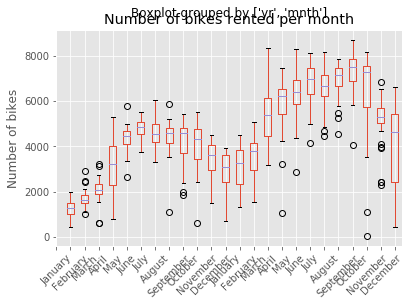

In [10]:
plt.style.use('ggplot')

bike_data.boxplot(column='cnt', by=['yr','mnth'])

plt.title('Number of bikes rented per month')
plt.xlabel('')
plt.xticks((np.arange(0,len(bike_data)/30,len(bike_data)/731)), calendar.month_name[1:13]*2, rotation=45)
plt.ylabel('Number of bikes')

plt.show()

In [11]:
# Pre-processing

X = bike_data[features.drop(['dteday'],['instant'])] # feature values 
y = bike_data[target]  # corresponding targets

In [12]:
# test size is set to 0.25
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [13]:
svr = SVR()
svr.fit(X_train, y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [14]:
svr_pred = svr.predict(X_test)

score_svr = r2_score(y_test, svr_pred)
rmse_svr = sqrt(mean_squared_error(y_test, svr_pred))

print("Score SVR: %f" % score_svr)
print("RMSE SVR: %f" % rmse_svr)

Score SVR: -0.012800
RMSE SVR: 1906.943855


In [15]:
# Tuning SVR with GridSearch

tuned_parameters = [{'C': [1000, 3000, 10000], 
                     'kernel': ['linear', 'rbf']}
                   ]

#svr_tuned = GridSearchCV(SVR (C=1), param_grid = tuned_parameters, scoring = 'mean_squared_error') #default 3-fold cross-validation, score method of the estimator
svr_tuned_GS = GridSearchCV(SVR (C=1), param_grid = tuned_parameters, scoring = 'r2', n_jobs=-1) #default 3-fold cross-validation, score method of the estimator

svr_tuned_GS.fit(X_train, y_train)

print (svr_tuned_GS)
print ('\n' "Best parameter from grid search: " + str(svr_tuned_GS.best_params_) +'\n')

GridSearchCV(cv=None, error_score='raise',
       estimator=SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'C': [1000, 3000, 10000], 'kernel': ['linear', 'rbf']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)

Best parameter from grid search: {'C': 3000, 'kernel': 'linear'}



In [16]:
# Validation - SVR tuned 

svr_tuned_pred_GS = svr_tuned_GS.predict(X_test)

score_svr_tuned_GS = r2_score(y_test, svr_tuned_pred_GS)
rmse_svr_tuned_GS = sqrt(mean_squared_error(y_test, svr_tuned_pred_GS))

print("SVR Results\n")

print("Score SVR: %f" % score_svr)
print("Score SVR tuned GS: %f" % score_svr_tuned_GS)

print("\nRMSE SVR: %f" % rmse_svr)
print("RMSE SVR tuned GS: %f" % rmse_svr_tuned_GS)

SVR Results

Score SVR: -0.012800
Score SVR tuned GS: 0.781939

RMSE SVR: 1906.943855
RMSE SVR tuned GS: 884.841220


In [17]:
# SVR tuned with RandomizesSearch
# may take a while!

# Parameters
param_dist = {  'C': sp_uniform (1000, 10000), 
                'kernel': ['linear']
             }

n_iter_search = 1

# MSE optimized
#SVR_tuned_RS = RandomizedSearchCV(SVR (C=1), param_distributions = param_dist, scoring = 'mean_squared_error', n_iter=n_iter_search)

# R^2 optimized
SVR_tuned_RS = RandomizedSearchCV(SVR (C=1), param_distributions = param_dist, scoring = 'r2', n_iter=n_iter_search)

# Fit
SVR_tuned_RS.fit(X_train, y_train)

# Best score and corresponding parameters.
print('best CV score from grid search: {0:f}'.format(SVR_tuned_RS.best_score_))
print('corresponding parameters: {}'.format(SVR_tuned_RS.best_params_))

# Predict and score
predict = SVR_tuned_RS.predict(X_test)

score_svr_tuned_RS = r2_score(y_test, predict)
rmse_svr_tuned_RS = sqrt(mean_squared_error(y_test, predict))

best CV score from grid search: 0.786233
corresponding parameters: {'C': 3661.2374050289413, 'kernel': 'linear'}


In [18]:
print('SVR Results\n')

print("Score SVR: %f" % score_svr)
print("Score SVR tuned GS: %f" % score_svr_tuned_GS)
print("Score SVR tuned RS: %f" % score_svr_tuned_RS)

print("\nRMSE SVR: %f" % rmse_svr)
print("RMSE SVR tuned GS: %f" % rmse_svr_tuned_GS)
print("RMSE SVR tuned RS: %f" % rmse_svr_tuned_RS)

SVR Results

Score SVR: -0.012800
Score SVR tuned GS: 0.781939
Score SVR tuned RS: 0.780231

RMSE SVR: 1906.943855
RMSE SVR tuned GS: 884.841220
RMSE SVR tuned RS: 888.300060


In [19]:
print('Results\n')

print("Score SVR: %f" % score_svr)
print("Score SVR tuned GS: %f" % score_svr_tuned_GS)
print("Score SVR tuned RS: %f" % score_svr_tuned_RS)

print('\n')
print("RMSE SVR: %f" % rmse_svr)
print("RMSE SVR tuned GS: %f" % rmse_svr_tuned_GS)
print("RMSE SVR tuned RS: %f" % rmse_svr_tuned_RS)



Results

Score SVR: -0.012800
Score SVR tuned GS: 0.781939
Score SVR tuned RS: 0.780231


RMSE SVR: 1906.943855
RMSE SVR tuned GS: 884.841220
RMSE SVR tuned RS: 888.300060


In [20]:
#SVR with GridSearch - for casual users

# Extracting
feature_cols_cas = bike_data.columns[:-3]  # all columns but last are features
target_col_cas = bike_data.columns[-3]  # last column is the target
print ("Feature columns:\n{}\n".format(feature_cols_cas))
print ("Target column:\n{}\n".format(target_col_cas))

# Pre-processing
X_cas = bike_data[feature_cols_cas.drop(['dteday'],['instant'])]  # feature values 
y_cas = bike_data[target_col_cas]  # corresponding targets

# Split Set
X_train_cas, X_test_cas, y_train_cas, y_test_cas = train_test_split(X_cas, y_cas)# test size is set to 0.25

# Tuning SVR
param_grid = [
             {'C': [1, 3, 10, 30, 100, 300, 1000, 3000],
              'kernel': ['linear', 'rbf']}
             ]

# MSR optimized
#svr_tuned_cas = GridSearchCV(SVR (C=1), param_grid = param_grid, scoring = 'mean_squared_error')

# R^2 optimized
svr_tuned_cas_GS = GridSearchCV(SVR (C=1), param_grid = param_grid, scoring = 'r2', n_jobs=-1)

# Fitting
svr_tuned_cas_GS.fit(X_train_cas, y_train_cas)

print (svr_tuned_cas_GS)
print ('\n' "Best parameter from grid search: {}".format(svr_tuned_cas_GS.best_params_))

Feature columns:
Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed'],
      dtype='object')

Target column:
casual

GridSearchCV(cv=None, error_score='raise',
       estimator=SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'C': [1, 3, 10, 30, 100, 300, 1000, 3000], 'kernel': ['linear', 'rbf']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)

Best parameter from grid search: {'C': 1000, 'kernel': 'linear'}


In [21]:
# SVR with RandomizesSearch - for casual users
# may take a while!

# Parameters
param_dist = {  'C': sp_uniform (300, 3000), 
                'kernel': ['linear']
             }

n_iter_search = 1

svr_tuned_cas_RS = RandomizedSearchCV(SVR (C=1), param_distributions = param_dist, scoring = 'r2', n_iter=n_iter_search)

# Fit
svr_tuned_cas_RS.fit(X_train_cas, y_train_cas)

# Best score and corresponding parameters.
print('best CV score from random search: {0:f}'.format(svr_tuned_cas_RS.best_score_))
print('corresponding parameters: {}'.format(svr_tuned_cas_RS.best_params_))

# Predict and score
predict = svr_tuned_cas_RS.predict(X_test)

score_SVR_tuned_RS = r2_score(y_test, predict)
rmse_SVR_tuned_RS = sqrt(mean_squared_error(y_test, predict))

best CV score from random search: 0.657966
corresponding parameters: {'C': 1220.108002653475, 'kernel': 'linear'}


In [22]:
#SVR with GridSearch - for registered users

# Extracting
feature_cols_reg = bike_data.columns[:-3]  # all columns but last are features
target_col_reg = bike_data.columns[-2]  # last column is the target
print ("Feature column(s):\n{}\n".format(feature_cols_reg))
print ("Target column:\n{}\n".format(target_col_reg))

# Pre-processing
X_reg = bike_data[feature_cols_reg.drop(['dteday'],['casual'])]  # feature values 
y_reg = bike_data[target_col_reg]  # corresponding targets

# Split
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg)# test size is set to 0.25

# Tuning SVR
param_grid = [
             {'C': [1000, 3000, 10000],
              'kernel': ['linear', 'rbf']}
             ]

#svr_tuned_reg = GridSearchCV(SVR (C=1), param_grid = param_grid, scoring = 'mean_squared_error')
svr_tuned_reg_GS = GridSearchCV(SVR (C=1), param_grid = param_grid, scoring = 'r2', n_jobs=-1)


# Fitting 
svr_tuned_reg_GS.fit(X_train_reg, y_train_reg)

print (svr_tuned_reg_GS)
print ('\n' "Best parameter from grid search:{}".format(svr_tuned_reg_GS.best_params_))

Feature column(s):
Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed'],
      dtype='object')

Target column:
registered

GridSearchCV(cv=None, error_score='raise',
       estimator=SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'C': [1000, 3000, 10000], 'kernel': ['linear', 'rbf']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)

Best parameter from grid search:{'C': 1000, 'kernel': 'linear'}


In [23]:
#SVR with RandomizesSearch - for registered users
# may take a while!

# Parameters
param_dist = {  'C': sp_uniform (300, 3000), 
                'kernel': ['linear']
             }

n_iter_search = 1

svr_tuned_reg_RS = RandomizedSearchCV(SVR (C=1), param_distributions = param_dist, scoring = 'r2', n_iter=n_iter_search)

# Fit
svr_tuned_reg_RS.fit(X_train_reg, y_train_reg)

# Best score and corresponding parameters.
print('best CV score from random search: {0:f}'.format(svr_tuned_reg_RS.best_score_))
print('corresponding parameters: {}'.format(svr_tuned_reg_RS.best_params_))

# Predict and score
predict = svr_tuned_reg_RS.predict(X_test)

score_SVR_tuned_reg_RS = r2_score(y_test, predict)
rmse_SVR_tuned_reg_RS = sqrt(mean_squared_error(y_test, predict))

best CV score from random search: 0.800973
corresponding parameters: {'C': 1120.4038475400198, 'kernel': 'linear'}


In [24]:
# Prediction

predict_sum_test = svr_tuned_cas_RS.predict(X_test) + svr_tuned_reg_RS.predict(X_test)

score = r2_score(y_test, predict_sum_test)
rmse = sqrt(mean_squared_error(y_test, predict_sum_test))

print ('Score cas: {0:f}'.format(r2_score(y_test_cas,svr_tuned_cas_RS.predict(X_test_cas))))
print ('Score reg: {0:f}'.format(r2_score(y_test_reg,svr_tuned_reg_RS.predict(X_test_reg))))
print ('Score sum: {0:f}'.format(score))
print ('\n')

print ('RMSE cas: {0:f}'.format(sqrt(mean_squared_error(y_test_cas,svr_tuned_cas_RS.predict(X_test_cas)))))
print ('RMSE reg: {0:f}'.format(sqrt(mean_squared_error(y_test_reg,svr_tuned_reg_RS.predict(X_test_reg)))))
print ('RMSE sum: {0:f}'.format(rmse))

Score cas: 0.641032
Score reg: 0.808502
Score sum: 0.794365


RMSE cas: 409.527636
RMSE reg: 657.437503
RMSE sum: 859.259204


In [25]:
# Results
print("Results as RMSE")
print('\n')
print("SVR: %f" % rmse_svr)
print("SVR tuned GS: %f" % rmse_svr_tuned_GS)
print("SVR tuned RS: %f" % rmse_svr_tuned_RS)
print('\n')

Results as RMSE


SVR: 1906.943855
SVR tuned GS: 884.841220
SVR tuned RS: 888.300060




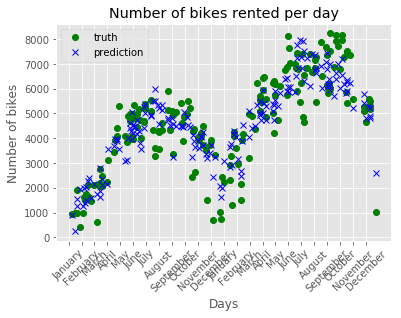

In [26]:
# Visulazation

predict_sum_all = svr_tuned_cas_RS.predict(X_test) + svr_tuned_reg_RS.predict(X_test)
predictions = pd.Series(predict_sum_all, index = y_test.index.values)

plt.style.use('ggplot')
plt.figure(1)

plt.plot(y_test,'go', label='truth')
plt.plot(predictions,'bx', label='prediction')

plt.title('Number of bikes rented per day')
plt.xlabel('Days')
plt.xticks((np.arange(0,len(bike_data),len(bike_data)/24)), calendar.month_name[1:13]*2, rotation=45)

plt.ylabel('Number of bikes')

plt.legend(loc='best')

plt.show()
